Summary: Occurences of differences were observed for different ranges of feature LSTAT, which is mainly responsible for the differences.
- For values between 3.2 and 10.15, A may predict 1 while B predicts 2,
- for values between 3.5 and 13.3, A may predict 2 while B predicts 1,
- for values above 6.75, A may predict 0 while B predicts 1.

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules
from tasks.boston_housing import make_task3 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Global explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [15]:
def explain(max_depth=None, tree_fig_size=(28, 14)):
    global tree
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_explain, y_explain)
    
    feature_importances = tree.feature_importances_
    feature_order = np.flip(np.argsort(feature_importances))
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_title('Relative feature importance')
    ax.scatter(np.flip(feature_importances[feature_order]),
               np.flip(comparer.feature_names[feature_order]))
    plt.show()
    
    if tree.get_depth() <= 3:
        fig, ax = plt.subplots(figsize=(14, 14))
        plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, node_ids=True, precision=2)
        plt.show()
    
    y_test = mclass_diff == np.where(comparer.class_names == focus_class)[0][0]
    print_rules(tree, feature_names, class_names, focus_class, X_test=X, y_test=y_test, precision=2, feature_order=feature_order)
    
    print('\ngenerated data evaluation:')
    print(classification_report(y_explain, tree.predict(X_explain), target_names=class_names))

    print('\noriginal data evaluation:')
    print(classification_report(mclass_diff == np.where(comparer.class_names == focus_class)[0][0], tree.predict(X), target_names=class_names))

## $(0,1)$

In [16]:
focus_class = '(0, 1)'

In [22]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 13min 36s, sys: 13.4 s, total: 13min 49s
Wall time: 18min 34s


In [17]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [18]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

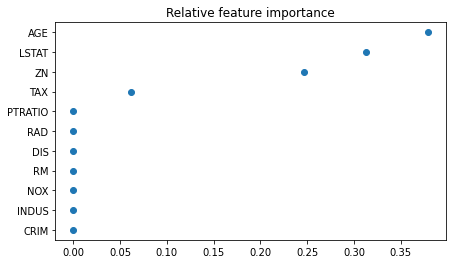

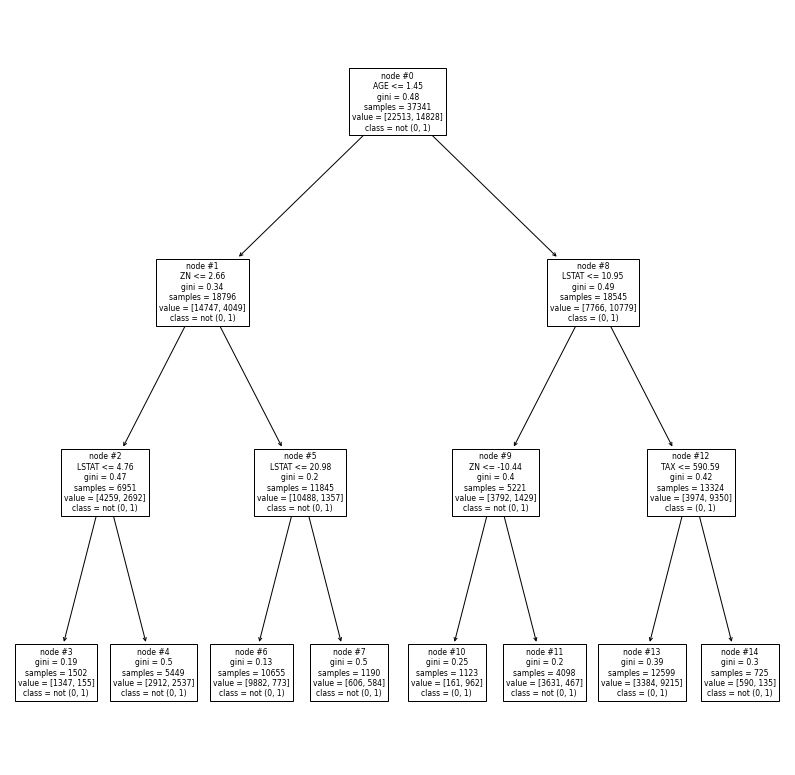

node #13: if (AGE > 1.45) and (LSTAT > 10.95) and (TAX <= 590.59) then class (0, 1) (covers 0.731 of 12599 instances)
node #10: if (AGE > 1.45) and (LSTAT <= 10.95) and (ZN <= -10.44) then class (0, 1) (covers 0.857 of 1123 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       0.80      0.84      0.82     22513
      (0, 1)       0.74      0.69      0.71     14828

    accuracy                           0.78     37341
   macro avg       0.77      0.76      0.77     37341
weighted avg       0.78      0.78      0.78     37341


original data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       0.99      0.79      0.88       233
      (0, 1)       0.18      0.85      0.30        13

    accuracy                           0.79       246
   macro avg       0.58      0.82      0.59       246
weighted avg       0.95      0.79      0.85       246



In [19]:
explain(max_depth=3)

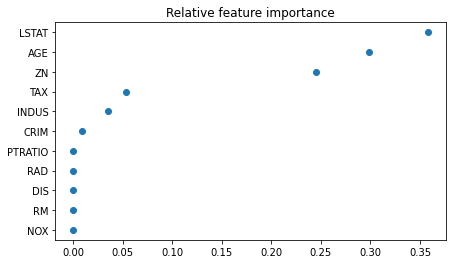

node #27: if (LSTAT > 10.95) and (AGE > 1.45) and (ZN > -0.38) and (TAX <= 590.59) then class (0, 1) (covers 0.623 of 7447 instances)
node #26: if (LSTAT > 10.95) and (AGE > 1.45) and (ZN <= -0.38) and (TAX <= 590.59) then class (0, 1) (covers 0.888 of 5152 instances)
node #7: if (LSTAT > 4.76) and (LSTAT <= 9.64) and (AGE <= 1.45) and (ZN <= 2.66) then class (0, 1) (covers 0.862 of 1611 instances)
node #15: if (LSTAT > 20.98) and (AGE <= 1.45) and (ZN > 2.66) and (TAX > 387.06) then class (0, 1) (covers 0.531 of 1073 instances)
node #20: if (LSTAT > 2.7) and (LSTAT <= 10.95) and (AGE > 1.45) and (ZN <= -10.44) then class (0, 1) (covers 0.921 of 1043 instances)
node #29: if (LSTAT > 10.95) and (LSTAT <= 13.28) and (AGE > 1.45) and (TAX > 590.59) then class (0, 1) (covers 0.851 of 94 instances)
node #5: if (LSTAT <= 4.76) and (AGE <= 1.45) and (ZN <= 2.66) and (INDUS > 24.13) then class (0, 1) (covers 0.56 of 84 instances)

generated data evaluation:
              precision    recall  f

In [20]:
explain(max_depth=4)

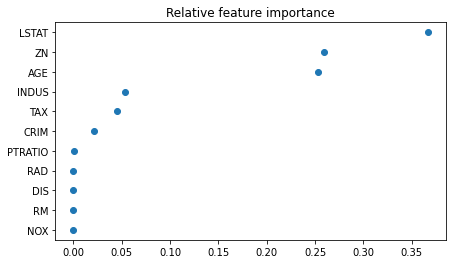

node #52: if (LSTAT > 10.95) and (ZN > -28.33) and (ZN <= -0.38) and (AGE > 1.45) and (TAX <= 590.59) then class (0, 1) (covers 0.901 of 5079 instances)
node #54: if (LSTAT > 10.95) and (LSTAT <= 18.01) and (ZN > -0.38) and (AGE > 1.45) and (TAX <= 590.59) then class (0, 1) (covers 0.507 of 4713 instances)
node #55: if (LSTAT > 18.01) and (ZN > -0.38) and (AGE > 1.45) and (TAX <= 590.59) then class (0, 1) (covers 0.823 of 2734 instances)
node #12: if (LSTAT > 4.76) and (LSTAT <= 9.64) and (ZN <= -8.93) and (AGE <= 1.45) then class (0, 1) (covers 0.903 of 1533 instances)
node #40: if (LSTAT > 2.7) and (LSTAT <= 10.95) and (ZN <= -10.44) and (AGE > 1.45) and (INDUS > 3.78) then class (0, 1) (covers 0.947 of 1005 instances)
node #31: if (LSTAT > 20.98) and (ZN > 2.66) and (AGE <= 1.45) and (TAX > 387.06) and (CRIM > 0.78) then class (0, 1) (covers 0.578 of 930 instances)
node #24: if (LSTAT > 5.54) and (LSTAT <= 20.98) and (ZN > 2.66) and (AGE <= 1.45) and (INDUS > 26.04) then class (0, 1

In [21]:
explain(max_depth=5)

## $(1, 2)$

In [22]:
focus_class = '(1, 2)'

In [6]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 12min 2s, sys: 10.3 s, total: 12min 12s
Wall time: 14min 34s


In [23]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [24]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

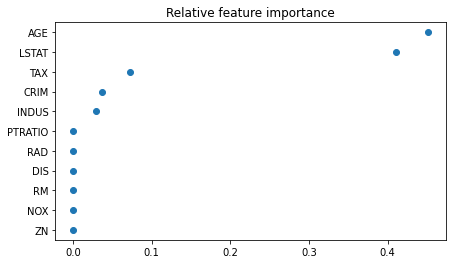

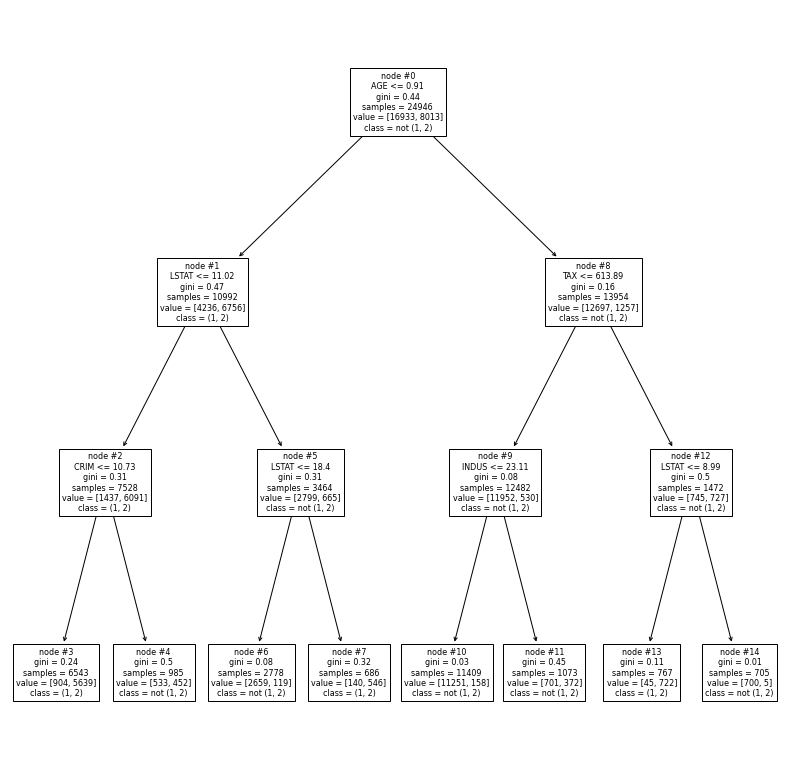

node #3: if (AGE <= 0.91) and (LSTAT <= 11.02) and (CRIM <= 10.73) then class (1, 2) (covers 0.862 of 6543 instances)
node #13: if (AGE > 0.91) and (LSTAT <= 8.99) and (TAX > 613.89) then class (1, 2) (covers 0.941 of 767 instances)
node #7: if (AGE <= 0.91) and (LSTAT > 18.4) then class (1, 2) (covers 0.796 of 686 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 2)       0.93      0.94      0.94     16933
      (1, 2)       0.86      0.86      0.86      8013

    accuracy                           0.91     24946
   macro avg       0.90      0.90      0.90     24946
weighted avg       0.91      0.91      0.91     24946


original data evaluation:
              precision    recall  f1-score   support

  not (1, 2)       1.00      0.74      0.85       245
      (1, 2)       0.02      1.00      0.03         1

    accuracy                           0.74       246
   macro avg       0.51      0.87      0.44       246
weighted avg      

In [25]:
explain(max_depth=3)

## $(2, 1)$

In [26]:
focus_class = '(2, 1)'

In [11]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 9min 35s, sys: 6.07 s, total: 9min 41s
Wall time: 10min 13s


In [27]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [28]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

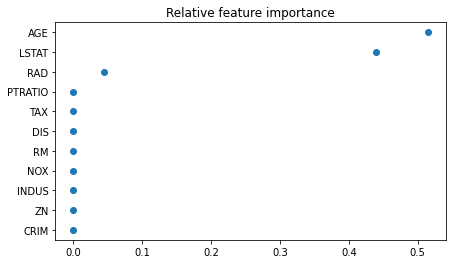

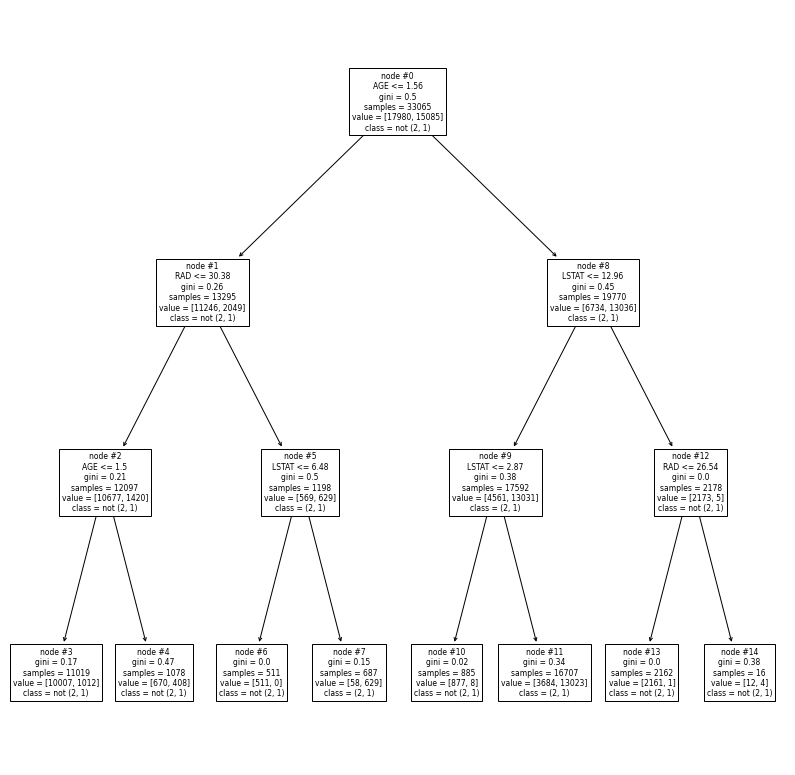

node #11: if (AGE > 1.56) and (LSTAT > 2.87) and (LSTAT <= 12.96) then class (2, 1) (covers 0.779 of 16707 instances)
node #7: if (AGE <= 1.56) and (LSTAT > 6.48) and (RAD > 30.38) then class (2, 1) (covers 0.916 of 687 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (2, 1)       0.91      0.79      0.85     17980
      (2, 1)       0.78      0.91      0.84     15085

    accuracy                           0.84     33065
   macro avg       0.85      0.85      0.84     33065
weighted avg       0.85      0.84      0.84     33065


original data evaluation:
              precision    recall  f1-score   support

  not (2, 1)       1.00      0.85      0.92       243
      (2, 1)       0.05      0.67      0.10         3

    accuracy                           0.85       246
   macro avg       0.52      0.76      0.51       246
weighted avg       0.98      0.85      0.91       246



In [29]:
explain(max_depth=3)